# Calculating band indices <img align="right" src="../img/LivingWales_logo.png" width="190" height="200">


* **Compatibility:** Notebook currently compatible with the `WDC` environment
* **Products used:** `sen2_l2a_gcp`

## Background
Remote sensing indices are combinations of spectral bands used to highlight features in the data and the underlying landscape.
Using Wales Open Data Cube's archive of analysis-ready satellite data, we can easily calculate a wide range of remote sensing indices that can be used to assist in mapping and monitoring features like vegetation and water consistently through time.


## Description
This notebook demonstrates how to:
 
* Calculate an index manually using `xarray`
* Calculate one or multiple indices using the function `calculate_indices` from `wdc_bandindices`
* Calculate indices while dropping original bands from a dataset
 
***

## Getting started
To run this analysis, run all the cells in the notebook starting with the "Load packages" cell. For help with running notebook cells, refer back to the [Jupyter Notebooks notebook](01_Introduction_jupyter_notebooks.ipynb).

In [1]:
import sys
sys.path.append("../wales_utils/data_cube_utilities")

import datacube
from time import time as time

from display_tools import rgb
from wdc_datahandling import cleaning_s2, cloud_coverage
from wdc_bandindices import calculate_indices

### Connect to the datacube
The next step is to connect to the datacube database.
The resulting `dc` datacube object can then be used to load data.
The `app` parameter is a unique name used to identify the notebook that does not have any effect on the analysis.

In [2]:
dc = datacube.Datacube(app='Calculating_band_indices')

## Create a query and load satellite data
To demonstrate how to compute a remote sensing index, we first need to load in a time series of satellite data for an area. 
We will use data from the Sentinel-2 satellite:

In [3]:
# Create a reusable query with coordinates indicated in EPSG:27700 CRS.
query = {
    'crs': 'EPSG:27700',
    'x': (195670, 199780),
    'y': (193630, 196810),
    'time': ('2020-06', '2020-10'),
    'measurements': ['blue', 'green', 'red','nir', 'scl'],
    'output_crs': 'EPSG:27700',
    'resolution': (-10, 10)}

start_load= time()

# Load available data from Sentinel-2 using the query dictionnary
dataset = dc.load(product='sen2_l2a_gcp',
                  **query)

end_load= time()

print("Datacube ready")
print("Took only " + str(round(end_load-start_load,2)) + " seconds to load " + str(len(dataset.time
    )*len(dataset.keys())) +" images from WDC for the specified extent.")

Datacube ready
Took only 9.46 seconds to load 460 images from WDC for the specified extent.


## Clean Sentinel-2 data

Within `WDC`, Sentinel-2 data are provided with same format as on the EODataDown platform (i.e., with `scl` cloud mask in a separate layer and a scaling factor of 10,000). 

In the next cell, we clean the Sentinel-2 data (i.e., cloud masking and reflectance normalisation) using one of the custom `WDC` libraries developed by Living Wales (`cleaning_s2()`) and drop timesteps which contain less than 20% of cloud-free area, see the [Sentinel2 data](06_Using_Sentinel2_data.ipynb) notebook for more explanations. 

In [4]:
# Let's clean the Sentinel-2 dataset (i.e., cloud masking and reflectance normalisation)
dataset_clean = cleaning_s2(dataset)

# Calculate the cloud coverage (%) for each date
cloud_percentage = cloud_coverage(dataset_clean)

# Let's remove the dates which contain less than 20% of cloud-free area
dataset_2use = dataset_clean.where(cloud_percentage<=20, drop=True)

### Plot the first image to see what our area looks like
We can use the `rgb` function to plot the first timestep in our dataset as a true colour RGB image:

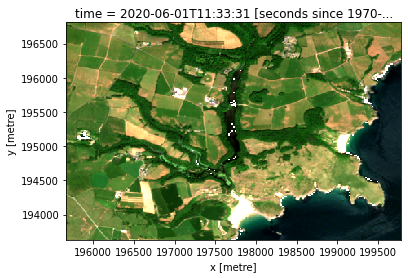

In [5]:
rgb(dataset_2use, index=0, robust=True)

## Calculate an index for this area manually
One of the most commonly used remote sensing indices is the Normalised Difference Vegetation Index or `NDVI`. 
This index uses the ratio of the red and near-infrared (NIR) bands to identify live green vegetation.
The formula for NDVI is:

$$
\begin{aligned}
\text{NDVI} & = \frac{(\text{NIR} - \text{Red})}{(\text{NIR} + \text{Red})} \\
\end{aligned}
$$

When interpreting this index, high values indicate vegetation, and low values indicate soil or water.

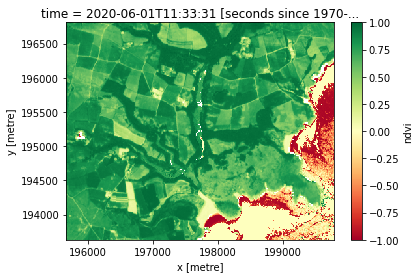

In [6]:
# Calculate NDVI using the formula above
dataset_2use['ndvi'] = (dataset_2use.nir - dataset_2use.red) / (dataset_2use.nir + dataset_2use.red)

# Plot the results for one time step to see what they look like:
dataset_2use.ndvi.isel(time=0).plot(vmin=-1, vmax=1, cmap='RdYlGn');

## Calculate an index for the same area using the `WDC`  `calculate_indices` function

The `calculate_indices` function provides an easier way to calculate a wide range of remote sensing indices, including:

- **ARI** (Anthocyanin reflectance index, Gitelson et al. 2009)
- **AWEI_ns** (Automated Water Extraction Index - no shadows, Feyisa 2014)
- **AWEI_sh** (Automated Water Extraction Index - shadows, Feyisa 2014)
- **BAEI** (Built-Up Area Extraction Index, Bouzekri et al. 2015)
- **BAI** (Burn Area Index, Martin 1998)
- **BSI** (Bare Soil Index, Rikimaru et al. 2002)
- **BUI** (Built-Up Index, He et al. 2010)
- **CIg** (Chlorophyll Index - green, Gitelson et al. 2005)
- **CIre** (Chlorophyll Index - red edge, Gitelson et al. 2005)
- **CMR** (Clay Minerals Ratio, Drury 1987)
- **EVI** (Enhanced Vegetation Index, Huete 2002)
- **FMR** (Ferrous Minerals Ratio, Segal 1982)
- **GNDVI** (Green Normalised Difference Vegetation Index, Gitelson and Merzlyak 1998)
- **IOR** (Iron Oxide Ratio, Segal 1982)
- **IRECI** (Inverted Red-Edge Chlorophyll Index, Clevers et al. 2000)
- **LAI** (Leaf Area Index, Boegh 2002)
- **MCARI2** (Modified Chlorophyll Absorption in Reflectance Index 2, Haboudane et al. 2004)
- **MNDWI** (Modified Normalised Difference Water Index, Xu 1996)
- **MSAVI** (Modified Soil Adjusted Vegetation Index, Qi et al. 1994)
- **MSI** (Moisture Stress Index, )
- **NBI** (New Built-Up Index, Jieli et al. 2010)
- **NBR** (Normalised Burn Ratio, Lopez Garcia 1991)
- **NDBI** (Normalised Difference Built-Up Index, Zha 2003)
- **NDCI** (Normalised Difference Chlorophyll Index, Mishra & Mishra, 2012)
- **NDMI** (Normalised Difference Moisture Index, Gao 1996)        
- **NDSI** (Normalised Difference Snow Index, Hall 1995)
- **NDTI** (Normalise Difference Tillage Index, Van Deventeret et al. 1997)
- **NDVI** (Normalised Difference Vegetation Index, Rouse 1973)
- **NDWI** (Normalised Difference Water Index, McFeeters 1996)
- **PSRI** (Plant Senescence Reflectance Index, Merzlyak et al. 1999)
- **SAVI** (Soil Adjusted Vegetation Index, Huete 1988)
- **S2REP** (Sentinel2 Red Edge Position, Frampton et al. 2013)
- **TCB** (Tasseled Cap Brightness, Crist 1985)
- **TCG** (Tasseled Cap Greeness, Crist 1985)
- **TCW** (Tasseled Cap Wetness, Crist 1985)        
- **TCB_GSO** (Tasseled Cap Brightness, Nedkov 2017)
- **TCG_GSO** (Tasseled Cap Greeness, Nedkov 2017)
- **TCW_GSO** (Tasseled Cap Wetness, Nedkov 2017)
- **VARIg** (Vegetation Index Green, Gitelson et al. 2002)
- **WDRVI** (Wide Dynamic Range Vegetation Index, Peng and Gitelson, 2011)
- **WI** (Water Index, Fisher 2016)
- **kNDVI** (Non-linear Normalised Difference Vegation Index, Camps-Valls et al. 2021)


### Using `calculate_indices`, we get the same result:


0.0-1.0 range. Applying the index to non-normalised reflectance can produce unexpected results; 
if required, resolve this by setting `normalise=True`


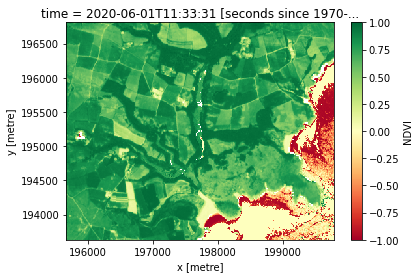

In [7]:
# Calculate NDVI using `calculate indices`
dataset_ndvi = calculate_indices(dataset_2use, index='NDVI', platform='SENTINEL_2')

# Plot the results 
dataset_ndvi.NDVI.isel(time=0).plot(vmin=-1, vmax=1, cmap='RdYlGn');


> **Note 1**: when using the `calculate_indices` function, you will have `WARNING` message(s). This simply a reminder as some coefficient-based indices (e.g. 'WI', 'BAEI', 'AWEI_ns', 'AWEI_sh', 'TCW', 'TCG', 'TCB', 'TCW_GSO', 'TCG_GSO', 'TCB_GSO', 'EVI', 'LAI', 'SAVI', 'MSAVI') produce different results if surface reflectance values are not scaled between 0.0 and 1.0 prior to calculating the index. When using the `cleaning_s2()` function, reflectances are normalised (i.e., 0.0-1.0); so the issue does not apply here. When not using `cleaning_s2()` function, please add `normalise=True`. To ignore warning messages, add `quiet=True`.

> **Note 2**: when using the `calculate_indices` function, it is important to set the `platform` parameter correctly. 
This is because Landsat(5-8) and Sentinel-2 satellite sensors may use different names for the same bands.


### Using calculate_indices to calculate multiple indices at once
The `calculate_indices` function makes it straightforward to calculate multiple remote sensing indices in one line of code.

In the example below, we will calculate `NDVI` as well as two common water indices: the Normalised Difference Water Index (`NDWI`), and the Soil Adjusted Vegetation Index (`SAVI`).
The new indices will appear in the list of `data_variables` below:

In [8]:
# Calculate multiple indices
ds_multi = calculate_indices(dataset_2use, index=['NDVI', 'NDWI', 'SAVI'], platform='SENTINEL_2',
                            quiet=True)
ds_multi


<xarray.Dataset>
Dimensions:      (time: 15, y: 318, x: 411)
Coordinates:
  * time         (time) datetime64[ns] 2020-06-01T11:33:31 ... 2020-10-14T11:...
  * y            (y) float64 1.968e+05 1.968e+05 ... 1.936e+05 1.936e+05
  * x            (x) float64 1.957e+05 1.957e+05 ... 1.998e+05 1.998e+05
    spatial_ref  int32 27700
Data variables:
    blue         (time, y, x) float64 0.0225 0.0194 0.0195 ... 0.0456 0.0469
    green        (time, y, x) float64 0.0661 0.0656 0.065 ... 0.043 0.0447
    red          (time, y, x) float64 0.0435 0.0414 0.0423 ... 0.0142 0.016
    nir          (time, y, x) float64 0.4124 0.4188 0.4188 ... 0.0093 0.0086
    ndvi         (time, y, x) float64 0.8092 0.8201 0.8165 ... -0.2085 -0.3008
    NDVI         (time, y, x) float64 0.8092 0.8201 0.8165 ... -0.2085 -0.3008
    NDWI         (time, y, x) float64 -0.7237 -0.7291 -0.7313 ... 0.6444 0.6773
    SAVI         (time, y, x) float64 0.5789 0.5896 0.5876 ... -0.01404 -0.02116
Attributes:
    crs:           EPSG:27700
    grid_mapping:  spatial_ref

### Dropping original bands from a dataset
We can also drop the original satellite bands from the dataset using `drop=True`. 
The dataset produced below should now only include the new `'NDVI', 'NDWI', 'SAVI'` bands under `data_variables`:

In [9]:
# Calculate multiple indices and drop original bands
ds_drop = calculate_indices(dataset_2use, 
                            index=['NDVI', 'NDWI', 'SAVI'], 
                            drop=True, 
                            platform='SENTINEL_2',
                            quiet=True)
ds_drop


Dropping bands ['blue', 'green', 'red', 'nir', 'ndvi']


<xarray.Dataset>
Dimensions:      (time: 15, y: 318, x: 411)
Coordinates:
  * time         (time) datetime64[ns] 2020-06-01T11:33:31 ... 2020-10-14T11:...
  * y            (y) float64 1.968e+05 1.968e+05 ... 1.936e+05 1.936e+05
  * x            (x) float64 1.957e+05 1.957e+05 ... 1.998e+05 1.998e+05
    spatial_ref  int32 27700
Data variables:
    NDVI         (time, y, x) float64 0.8092 0.8201 0.8165 ... -0.2085 -0.3008
    NDWI         (time, y, x) float64 -0.7237 -0.7291 -0.7313 ... 0.6444 0.6773
    SAVI         (time, y, x) float64 0.5789 0.5896 0.5876 ... -0.01404 -0.02116
Attributes:
    crs:           EPSG:27700
    grid_mapping:  spatial_ref

Plotting ...
(Please wait until images appear. This may take a few seconds)


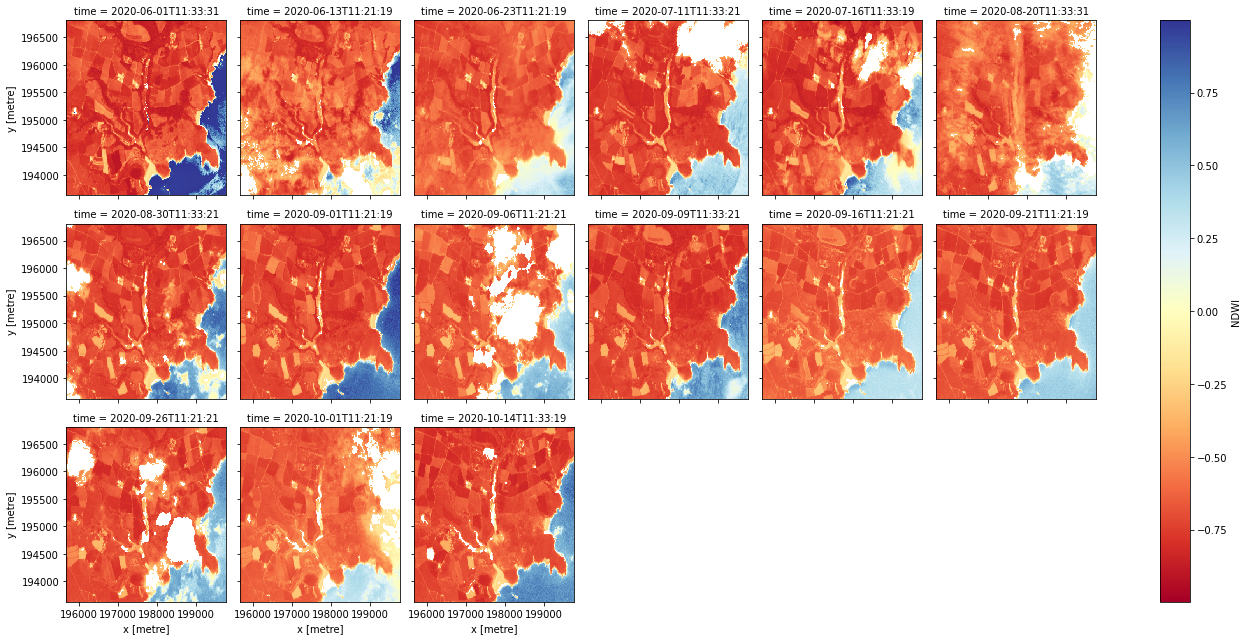

In [16]:
# This is the simplest way to plot
# Note that high values are likely to be vegetation.
print("Plotting ...")
print("(Please wait until images appear. This may take a few seconds)")

ds_drop.NDWI.plot(col="time", col_wrap=6, cmap="RdYlBu");

## Recommended next steps

For more advanced information about working with Jupyter Notebooks or JupyterLab, see the [JupyterLab documentation](https://jupyterlab.readthedocs.io/en/stable/user/notebook.html).

To continue working through the notebooks in this beginner's guide, the following notebooks are designed to be worked through in the following order:

1. **[Introduction to jupyter Notebooks](01_Introduction_jupyter_notebooks.ipynb)**
2. **[Wales Open Data Cube](02_Wales_Open_Data_Cube.ipynb)**
3. **[Products and measurements](03_Products_and_measurements.ipynb)**
4. **[Loading data in WDC](04_Loading_data.ipynb)**
5. **[Plotting](05_Plotting.ipynb)**
6. **[Using Sentinel-2 data](06_Using_Sentinel2_data.ipynb)**
7. **Calculating band indices (this notebook)**
8. **[Generating composites](08_Generating_composites.ipynb)**
9. **[Zonal_statistics](09_Zonal_statistics.ipynb)**


Once you have worked through the beginner's guide, you can explore the "Case Studies" directory, which provides examples of applications within Wales Open Data Cube.